# Plotting Morisita-Horn similarity

In our manuscript, we use Morisita-Horn similarity to compare repertoires across subjects. Details of how we calculated MH similarity, as well as code and data, can be found [**here**](LINK). In this notebook, we're going to make the following three figure panels:

  * Line plot of intra- and inter-subject MH similarity (**Figure 1d** and **Extended Data Figure 3**)
  * Clustermap of pairwise MH similarities (**Figure 1g**)
  * Barplot of MH similarity by isotype class (**Figure 1h**)
  
The following Python packages are required to run the code in this notebook:
  * numpy
  * pandas
  * scipy
  * matplotlib
  * seaborn
  * [abutils](https://www.github.com/briney/abutils)

They can be install by running `pip install numpy pandas scipy matplotlib seaborn abutils`

In [2]:
from __future__ import print_function

import os
import re
import sys

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import stats

from abutils.utils.color import truncate_colormap, hex_to_rgb
from abutils.utils.pipeline import list_files

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Comparison class

This class makes it easier to read, manage and process the MH similarity data for a single pairwise comparison. Input is a string containing the similarity information for a single comparison (read directly from the MH similarity output file, which can be generated with [**this code**](LINK))

In [3]:
class Comparison(object):
    """docstring for Comparison"""
    def __init__(self, raw_data):
        super(Comparison, self).__init__()
        self.raw_data = raw_data
        self.raw_lines = [l.strip() for l in self.raw_data.split('\n')]
        self._subjects = None
        self._comparison_type = None
        self._sizes = None
        self._scores = None
        self._means = None
        self._color = None
        self._primary = None

    @property
    def subjects(self):
        if self._subjects is None:
            self._subjects = sorted(list(set(self.raw_lines[0].split())))
        return self._subjects
    
    @property
    def primary(self):
        return self._primary
    
    @primary.setter
    def primary(self, primary):
        self._primary = primary
    
    @property
    def secondary(self):
        if self._primary is not None:
            sec = [s for s in self.subjects if s != self.primary]
            if len(sec) == 0:
                return None
            else:
                return sec[0]
        else:
            return None

    @property
    def comparison_type(self):
        if self._comparison_type is None:
            if len(self.subjects) == 1:
                self._comparison_type = 'intra'
            else:
                self._comparison_type = 'inter'
        return self._comparison_type
    
    @property
    def scores(self):
        if self._scores is None:
            scores = {}
            for line in self.raw_lines[1:]:
                if line.strip():
                    split_line = line.strip().split()
                    size, _scores = int(split_line[0]), [float(s) for s in split_line[1:]]
                    scores[size] = _scores
            self._scores = scores
        return self._scores
    
    @property
    def sizes(self):
        if self._sizes is None:
            self._sizes = sorted(self.scores.keys())
        return self._sizes
    
    @property
    def means(self):
        if self._means is None:
            means = {}
            for size, scores in self.scores.items():
                means[size] = np.mean(scores)
            self._means = means
        return self._means
    
    @property
    def color(self):
        return self._color
    
    @color.setter
    def color(self, color):
        self._color = color
    
    def mean(self, size):
        return self.means.get(size, None)
    
    def ci(self, size, percentile=95):
        scores = self.scores.get(size, None)
        if scores is None:
            return None
        mean = np.mean(scores)
        std = np.std(scores)
        lower_ci, upper_ci = stats.norm.interval(percentile / 100., loc=mean, scale=std)
        return (lower_ci, upper_ci)

    def plot_data(self, percentile=95, upper_limit=None, lower_limit=None):
        sizes = self.sizes
        if lower_limit is not None:
            sizes = [s for s in sizes if s >= lower_limit]
        if upper_limit is not None:
            sizes = [s for s in sizes if s <= upper_limit]
        means = []
        lower_cis = []
        upper_cis = []
        for s in sizes:
            means.append(self.mean(s))
            lci, uci = self.ci(s, percentile=percentile)
            lower_cis.append(lci)
            upper_cis.append(uci)
        return sizes, means, lower_cis, upper_cis

### Read the similarity datafile and make Comparison objects

The header for each pairwise comparison in the datafile starts with a `'#'`, so if we read the entire datafile and split by the `'#'` character, we get a list of strings each containing the similarity data for a single pairwise comparison.

If you've generated your own MH similarity data using the above data processing code, by default it will be saved to `'../01_data_processing/data/user-calculated_mh_similarity/mh-similarities_combined.txt'`. Replacing the path to the default datafile with this path will create plots based on your data rather than the data in the paper.

In [7]:
with open('../data_processing/data/user-calculated_mh_similarity/mh-similarities_combined.txt') as f:
    data = f.read()
comps = [Comparison(d) for d in data.split('#') if d.strip()]

In [20]:
comps = [comps[0]] + [comps[1]] + [comps[4]] + comps[7:]

### Subjects and colors

The list of subject colors is maintained throughout all of the figures in the manuscript. It's similar to the standard HLS palette created by Seaborn, but with the 4th and 5th colors modified slightly to make them more distinguishable.

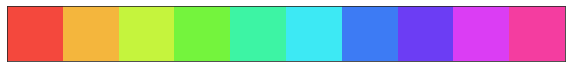

In [23]:
subjects = sorted(list(set([subject for comp in comps for subject in comp.subjects])))

color_list = sns.hls_palette(10, s=0.9)
color_list[3] = sns.hls_palette(11, s=0.9)[3]
color_list[4] = sns.hls_palette(12, s=0.9)[5]
sns.palplot(color_list)
plt.show()

color_dict = {s: c for s, c in zip(subjects, color_list)}

## Line plots of MH similarity

In [41]:
def similarity_plot(comparisons, colors=None, figfile=None,
                    fill_between_alpha=0.2, line_alpha=0.85,
                    legend_location='lower right'):
    
    # set color values
    if colors is None:
        if all([c.color is not None for c in comparisons]):
            colors = [c.color for c in comparisons]
        else:
            colors = sns.hls_palette(s=0.8, n_colors=len(comparisons))
    sns.set_style('white')
    fig = plt.figure(figsize=(6, 6))
    plt.xscale('log')
    
    # plot the CI shading first
    for i, comp in enumerate(comparisons):
        sizes, means, lower_cis, upper_cis = comp.plot_data()
        plt.fill_between(sizes,
                         lower_cis,
                         upper_cis,
                         color=colors[i],
                         alpha=fill_between_alpha)
    
    # iterate through the subjects again and plot the mean lines
    # so that they're on top of all of the CI shading
    for i, comp in enumerate(comparisons):
        sizes, means, lower_cis, upper_cis = comp.plot_data()
        label = comp.subjects #if comp.comparison_type == 'intra' else [comp.primary, comp.secondary]
        plt.plot(sizes,
                 means,
                 linewidth=2,
                 c=colors[i],
                 alpha=line_alpha,
                 label=' vs '.join(label))
    
    # plot the horizontal reference lines
    for y in np.arange(0., 1.01, 0.2):
        ls = ':'
        lw = 1
        alpha=0.5
        plt.axhline(y=y, xmin=0, xmax=10, linewidth=lw, color='k', linestyle=ls, alpha=alpha)
    
    # plot configuration
    ax = plt.gca()
    ax.set_ylim(0, 1.01)
    # axis labels
    ax.set_ylabel('Morisita-Horn similarity', fontsize=14)
    ax.set_xlabel('Sequence count', fontsize=14)
    # change the fontsize of the tick labels
    ax.tick_params(axis='x', labelsize=12, length=6, width=1.25, pad=8, top=False)
    ax.tick_params(axis='x', which='minor', labelsize=0, length=4, width=1, top=False)
    ax.tick_params(axis='y', which='major', labelsize=12, length=0, pad=6, right=False)
    # hide top, left and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # configure the legend
    handles, labels = ax.get_legend_handles_labels()
    handles=[handles[0]]+[handles[3]]+[handles[1]]+[handles[4]]
    labels=['D103 Intra-year', '327059 Intra-year', 'D103 Inter-year', '327059 Inter-year']
    legend = ax.legend(handles, labels, loc=legend_location, fontsize=12,
                       frameon=True, borderpad=0.5, labelspacing=0.4)
    legend.get_frame().set_facecolor('w')
    legend.get_frame().set_edgecolor('w')
    
    # save or show the image
    if figfile is None:
        plt.show()
    else:
        plt.tight_layout()
        plt.savefig(figfile)


def plot_single_comparison_set(subject, figfile=None, legend_location='lower right'):
    # retrieve and sort the comparison data
    _comps = [c for c in comps if subject in c.subjects]
    for c in _comps:
        c.primary = subject
    intra = [c for c in _comps if c.comparison_type == 'intra']
    inter = sorted([c for c in _comps if c.comparison_type == 'inter'], key=lambda x: x.secondary)
    _comps = intra + inter
    
    # retrieve and order the color values
    colors = [color_dict[subject]] + [color_dict[c.secondary] for c in inter]
    
    # make the similarity plot
    similarity_plot(_comps, colors=colors,
                    legend_location=legend_location,
                    figfile=figfile)

### Make the MH similarity line plots

By default, the plots will be shown inline but not saved. To save the figure files (in PDF format), uncomment the `figfile=...` line below. To change the format in which the file is saved (JPG, TIFF, etc), simply change the extension of the figfile name (replace `.pdf` with `.jpg`, for example).

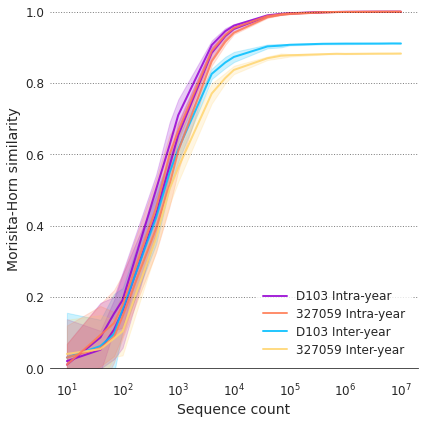

In [42]:
similarity_plot(comps, colors=['#9501d3', '#00befe', '#9501d3', '#FF7B54', '#FFD56F', '#FF7B54'], 
                figfile='./figures/mh-similarity.pdf'
               )

## Clustermap of cross-subject similarity

Transform comparison data into a DataFrame, using the 1,000,000 sequence sample size as the comparison measure

In [59]:
with open('../data_processing/data/user-calculated_mh_similarity_by-biorep/all-mh-similarities_combined.txt') as f:
    data = f.read()
biorep_comps = [Comparison(d) for d in data.split('#') if d.strip()]

In [60]:
comp_dict = {}
for comp in biorep_comps:
    subjects = comp.subjects
    if len(subjects) == 1:
        subjects = subjects * 2
    s1, s2 = subjects
    if s1 not in comp_dict:
        comp_dict[s1] = {}
    if s2 not in comp_dict:
        comp_dict[s2] = {}
    score = comp.means[100000]
    comp_dict[s1][s2] = score
    comp_dict[s2][s1] = score
    
comp_df = pd.DataFrame(comp_dict)

In [61]:
comp_df.columns = [yl.replace('_', ' ') for yl in comp_df.columns]
comp_df.index = [yl.replace('_', ' ') for yl in comp_df.index]

To save the clustermap figure (instead of showing inline but not saving, which is the default behavior), comment out the `plt.show()` line and uncomment the last two lines in the code block. If you'd like to save the figure in a format other than PDF, replace the extension of the filename to your desired format (`.jpg` or `.png`, for example).

Note that we tweaked this figure slightly in Illustrator to make it a little more visually appealing. The following edits were made:
  * Removed the top dendrogram (currently, Seaborn doesn't support clustering along an axis without also showing the dendrogram in the plot)
  * Increased the line weight of the left dendrogram
  * Moved the x-axis labels to the top of the clustermap
  * Removed the colorbar

In [62]:
color_list=['#FF7B54']*6 + ['#FFD56F']*6 + ['#9501d3']*6 + ['#00befe']*6

<Figure size 504x288 with 0 Axes>

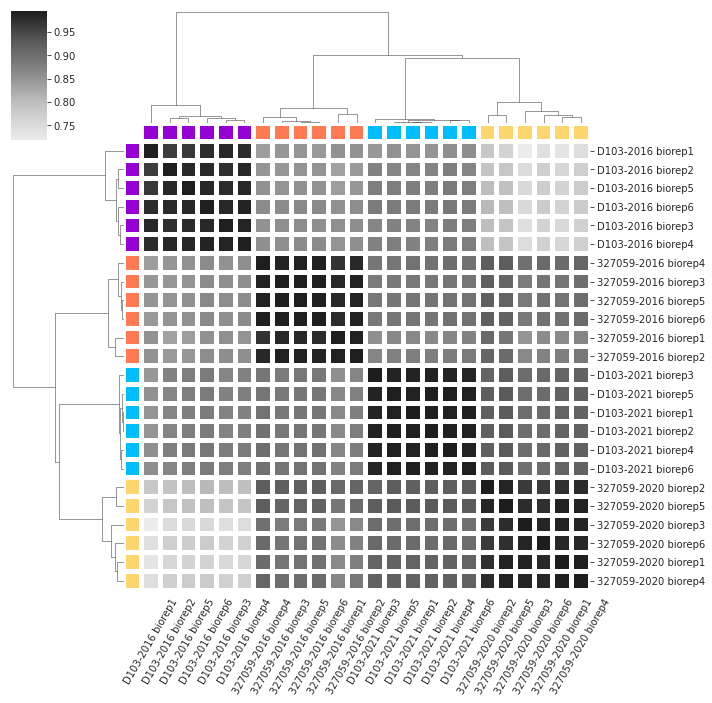

<Figure size 432x288 with 0 Axes>

In [64]:
plt.figure(figsize=[7, 4])

cm = sns.clustermap(comp_df, cmap=truncate_colormap('Greys', minval=0.15, maxval=0.9),
                    linewidth=4, row_colors=color_list, col_colors=color_list
                   )

ax = cm.ax_heatmap
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=10)

plt.show()

plt.tight_layout()
cm.savefig('./figures/similarity_clustermap.pdf')

## Box/scatter plot of MH similarity by isotype

To get a better idea of the relative contributions of memory (antigen experienced) and naive (antigen inexperienced) repertoires on overall repertoire similarity, we grouped sequences into "isotype classes" and computed MH similarity on each of the classes. The isotype classes are:

  * **IgM, with less than two mutations:** these sequences are not class-switched and are minimally mutated, meaning they should be enriched in sequences from naive B cells
  * **IgM, with two or more mutations:** these sequences are not class-switched but have evidence of somatic mutation, suggesting enrichment of sequences from IgM memory B cells.
  * **IgG:** these sequences are class-switched, indicating they come exclusively from IgG memory B cells.
  
First, we load all of the datasets:

In [51]:
# all sequences
all_comps = comps

# IgM with less than 2 mutations
with open('../data_processing/data/user-calculated_mh_similarity-by-isotype/mh-similarities_combined.txt') as f:
    data = f.read()
igmlte1_comps = [Comparison(d) for d in data.split('#') if d.strip() and 'IgM-lt2' in Comparison(d).raw_lines[0].split()[0]]

# IgM with 2 or more mutations
with open('../data_processing/data/user-calculated_mh_similarity-by-isotype/mh-similarities_combined.txt') as f:
    data = f.read()
igmgt1_comps = [Comparison(d) for d in data.split('#') if d.strip() and 'IgM-gte2' in Comparison(d).raw_lines[0].split()[0]]

# IgG
with open('../data_processing/data/user-calculated_mh_similarity-by-isotype/mh-similarities_combined.txt') as f:
    data = f.read()
igg_comps = [Comparison(d) for d in data.split('#') if d.strip() and 'IgG' in Comparison(d).raw_lines[0].split()[0]]

### Combine all of the isotype data into a single DataFrame

In [52]:
data = []

for i, comp in enumerate(all_comps):
    d = {'num': i, 'Morisita-Horn similarity': comp.means[1000000],
         'isotype': 'All', 'Comparison type': comp.comparison_type}
    data.append(d)
for i, comp in enumerate(igmlte1_comps):
    d = {'num': i, 'Morisita-Horn similarity': comp.means[1000000],
         'isotype': 'IgM (<2 mutations)', 'Comparison type': comp.comparison_type}
    data.append(d)
for i, comp in enumerate(igmgt1_comps):
    d = {'num': i, 'Morisita-Horn similarity': comp.means[1000000],
         'isotype': 'IgM (2+ mutations)', 'Comparison type': comp.comparison_type}
    data.append(d)
for i, comp in enumerate(igg_comps):
    d = {'num': i, 'Morisita-Horn similarity': comp.means[1000000],
         'isotype': 'IgG', 'Comparison type': comp.comparison_type}
    data.append(d)
    
df = pd.DataFrame(data)
df['Comparison type']=[ct+'-year' for ct in df['Comparison type']]

### Make the box/scatter plot

By default, the figure will be shown inline and not saved. To save the plot, comment out the `plt.show()` line and uncomment the last two lines of the code block.

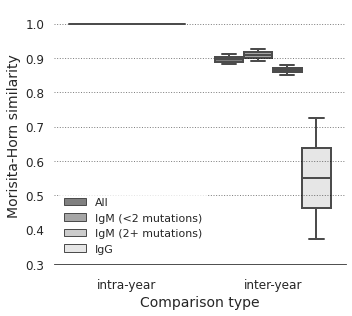

In [57]:
sns.set_style('white')
plt.figure(figsize=(5, 4.5))

# make the boxplot
box = sns.boxplot(data=df, x='Comparison type', y='Morisita-Horn similarity', hue='isotype', fliersize=0, saturation=1.,
            palette=['0.5', '0.65', '0.8', '0.9'],
            hue_order=['All', 'IgM (<2 mutations)', 'IgM (2+ mutations)', 'IgG'],
            linewidth=2)

# draw the horizontal reference lines
for y in np.arange(0.5, 1.01, 0.1):
    ls = ':'
    lw = 1
    alpha=0.5
    plt.axhline(y=y, xmin=0, xmax=10, linewidth=lw, color='k', linestyle=ls, alpha=alpha)

# style the plot
ax = plt.gca()
#axis limits and labels
ax.set_ylim([0.3, 1.05])
ax.set_ylabel('Morisita-Horn similarity', fontsize=14)
ax.set_xlabel('Comparison type', fontsize=14)
# axis tick appearance
ax.tick_params(axis='x', labelsize=12, direction='out', width=1.5, length=6, pad=8, top=False)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=4, right=False, left=False)
# remove top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# configure the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:4], labels[:4], loc='lower left', fontsize=11, frameon=True)
legend.get_frame().set_facecolor('w')
legend.get_frame().set_edgecolor('w')

plt.tight_layout()
plt.savefig('./figures/similarity-boxplot_by-isotype.pdf')